# Problem set 3 (43 + 35 = 78 pts)

# Making GANs great (43 pts)

GAN is typical example of high quality generative model. But we are still able to improve it. $G$ is model which maps latent distribution $p_z$ to the output $p_g$. Learning such $G$ that $p_g$ match original data distribution $p_d$ is quite complex task. In general $p_z$ is modeled by normal distribution. The reason for that is simplicity of sampling. But doing this we apply strong limitations on our model. It results in huge number of bad samples (non realistic images). To fix this problem we will correct latent distribution - decrease probability for "bad" samples and increase for "good" ones. Defining the criteria of "good" is not simple in general. So to find solution let's consider derivation for optimal discriminator:

$$D^*(x) = \frac{p_d(x)}{p_d(x) + p_g(x)}$$

Defining $d(x) = \mathrm{logit}(D(x))$ we can rewrite previous expression:

$$p_d(x) = p_g(x)\exp(d(x))$$

Since $p_g(x)$ induced by $p_z$ and $G$:

$$p^*(z) = p_z(z)\exp(d(G(z)))$$

We found the corrected distribution. Similar steps can be applied to non-standard GANs such as Wasserstein GAN (WGAN).

In this task you will be asked to improve the quality by correction of latent distribution for WGAN. An obvious question to ask is: "Why do we take WGAN?". You will answer it by yourself!

## Theoretical part (10 pts)

Suppose we have two 2D distributions: $P_\theta(x,\theta)$ and $P_*(x,\theta^*)$, where $\theta$ some parameter, $\theta^*$ is known fixed value, $x$ is random variable which has uniform distribution $x \sim U(0,1)$. In other words we have two horisontal lines in 2D space with certain $y$ position and $x$ uniformly distributed on the segment [0,1]. Find analytically distance between this distributions in different metrics for all possible values of $\theta$: 

1) KL divergence (2 pts)

2) JS divergence (3 pts)

3) Wasserstein distance (3 pts)

Suppose we would like to optimize parameter $\theta$ in order to fit target distribution $P_*$ with our parametrised distribution $P_\theta$. Which distance will you choose for this task? Why? (2 pts)

## Solution

### 1. KL divegrence
$ P_{\theta}(x, \theta) $ and $ P_{*}(x, \theta ^*) \in \1 &\text{if }0 \leq x \leq 1 $ 

$$ D_{KL}(P_{\theta}(x, \theta) || P_{*}(x, \theta ^*)) = \int\limits_{-\infty}^{+\infty}P_{\theta}(x, \theta) \cdot \text{ln}\frac{P_{\theta}(x, \theta)}{P_{*}(x, \theta^*)} dx $$


$$ D_{KL}(P_{\theta}(x, \theta) || P_{*}(x, \theta ^*)) = \int\limits_{0}^{1}\text{ln}\frac{P_{\theta}(x, \theta)}{P_{*}(x, \theta^*)} dx $$

$$ D_{KL}(P_{\theta}(x, \theta) || P_{*}(x, \theta ^*)) = \int\limits_{0}^{1}\text{ln}\frac{1}{1} dx = 0 $$

#### JS divergence

$$ JS(P_{\theta}  P_{*}) = \frac{1}{2}D_{KL}(P_{\theta}  M) + \frac{1}{2}D_{KL}(P_{*} || M) $$

$$ M = \frac{1}{2}(P_{\theta} + P_{*}) $$


$$P_{\theta}(y) = P_{*}(y) = 1\ \forall\ y \in [0, 1]$$.

$$M(x, y) = \frac{1}{2}\ \forall\ (x, y) \in [0, 1]$$.

And 
$$
D_{KL}(P_{\theta} || M) = \int\int P_{\theta}(x, y)\log\frac{P_{\theta}(x,y)}{M(x,y)}dxdy=\int\limits_{0}^{1}\int\limits_{0}^{1}P_{\theta}(x,y)\log \frac{2P_{\theta}(x,y)}{1}dxdy = \int\limits_{0}^{1}\int\limits_{0}^{1}\log(2P_{\theta}(x,y))dxdy = \log 2
$$

And 

$$
JS(P_{\theta} || P_{*}) = \frac{1}{2} \text{ln}2 + \frac{1}{2} \log 2 = \log 2
$$

#### Wasserstein distance

$$ W(P_{\theta} || P_{*}) = \text{inf}_{\gamma \in \Gamma (P_{\theta}, P_{*}}) \int _{\mathbb{R}^2 \times \mathbb{R}^2}||x - y||_2 d\gamma (x,y) $$ 



$$ W(P_{\theta} || P_{*}) = \int\limits_{0}^{1}\int\limits_{0}^{1} ||(x, \theta) - (y, \theta^* + (x - \frac{1}{2})(\theta - \theta^*)||_2 dxdy $$


$$ W(P_{\theta} || P_{*}) = |\theta - \theta ^*| $$

## Practical part

Here you will implement WGAN-GP and train it!

In [1]:
!pip install -q git+https://github.com/kwotsin/mimicry.git torchmetrics torch-fidelity gdown

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
pyvista 0.23.1 requires meshio>=3.3.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
google-cloud-storage 1.31.0 requires google-auth<2.0dev,>=1.11.0, but you have google-auth 2.18.0 which is incompatible.
google-cloud-core 1.7.1 requires google-auth<2.0dev,>=1.24.0, but you have google-auth 2.18.0 which is incompatible.
google-api-core 1.25.1 requires google-auth<2.0dev,>=1.21.1, but you have google-auth 2.18.0 which is incompatible.
google-api-core 1.25.1 requires six>=1.13.0, but you have six 1.12.0 which is incompatible.
deepfield 0.1.0 requires pytest==3.8.0, but you have pytest 7.1.1 which is incompatible.
deepfield 0.1.0 requires vtk==9.0.1, but you have vtk 9.0.2 which is in

In [31]:
import torch
import torch_mimicry as tmim
import torchvision as tv
import gdown

import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CelebA
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as dist
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance as FID
import warnings
import wandb
warnings.filterwarnings("ignore")

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)

cuda:3


For simplicity we will take architectures for generator and discriminator from open source library torch-mimicry (you are free to change output size of model)

In [32]:
G = tmim.nets.wgan_gp.wgan_gp_64.WGANGPGenerator64()
D = tmim.nets.wgan_gp.wgan_gp_64.WGANGPDiscriminator64()

## Your work starts here

### The first task is to implement loss functions for WGAN-GP (8 pts)

1) Implement loss function for discriminator (1 pts)

2) Implement loss function for generator (1 pts)

3) Implement gradient penalty for discriminator optimization (6 pts)

In [33]:
def loss_D(d_fake,d_real):
    # define the loss of discriminator based on d_fake = D(G(z)) and d_real = D(x)
    return (-1)*(torch.mean(d_real) - torch.mean(d_fake))

In [34]:
def loss_G(d_fake):
    # define the loss of generator based on output_fake = D(G(z))
    return (-1)*torch.mean(d_fake)

The most important moment in training WGAN-GP is gradient penalty. It is added to discriminator loss to ensure stability. Your goal is to implement following steps:

1) For given $N$ real images $x_{\mathrm{real}}$ and $N$ fake images $x_{\mathrm{fake}}$ compute random interpolation between real and fake samples in following way:

(use .detach() function over $x_{\mathrm{fake}}$ in order to get tensor without gradient graph)

$$x_{\mathrm{interpolation}} = \alpha x_{\mathrm{real}} + (1-\alpha)x_{\mathrm{fake}}$$

where $\alpha \sim U(0,1)$ (sampled from uniform distribution), $x_{\mathrm{real}}$ is of size $[N,3,H,W]$, $x_{\mathrm{fake}}$ is of size $[N,3,H,W]$ and $\alpha$ is of size $[N]$

2) Compute gradient of discriminator output with respect to input (interpolated samples)

$$\nabla D(x_{\mathrm{interpolation}})$$

It will be of size $[N,3,H,W]$, for ease of use reshape it to $[N,3HW]$

3) Compute loss:

$$\mathcal{L} = \mathrm{E}(\|\nabla D(x_{\mathrm{interpolation}})\|_2 - 1)^2$$

Second norm $\|\cdot\|_2$ is taken over second dimension (after reshaping in previous step), mean $\mathrm{E}$ is taken over first dimension. 

In [35]:
def loss_GP(x_fake, x_real, D):
    # compute gradient penalty
    x_fake = x_fake.detach()
    N = x_real.shape[0]

    coefs = torch.rand((N, 1, 1, 1), device=x_real.device)

    x_interpolat = (coefs * x_real + (1 - coefs) * x_fake).requires_grad_(True)
    d_interp = D(x_interpolat)
    grads= torch.autograd.grad(outputs=d_interp,
                               inputs=x_interpolat,
                               grad_outputs=torch.ones_like(d_interp),
                               create_graph=True,
                               retain_graph=True)[0]
    grads = grads.view(N, -1)
    return ((grads.norm(2, dim=1) - 1) ** 2).mean()

### The second task is to implement standard stuff: (6 pts)

1) Download Celeba dataset, apply appropriate data transformation, create dataloader (3 pts)

You can use batch size equal 64. Do not forget to use materials shared on seminars!

2) Initialize optimizers for discriminator and generator (3 pts)

You can take Adam optimizer with **lr** $= 2\cdot 10^{-4}$, $\beta_1$ = 0 and $\beta_2$ = 0.9

In [37]:
# your code is here
# gdown.download("https://drive.google.com/file/d/1bQuE4UjImPJryttD9z3Re_rvJDI_JR8A/view?usp=sharing",
#                "./GAN_dataset.zip",quiet=False, fuzzy=True)
# !unzip -q ./data.zip

In [38]:
class Dataset(object):
    def __init__(self,data_path,transform=None):
        self.path = data_path
        self.files = os.listdir(data_path)
        self.transform = transform
        
    def __getitem__(self,idx):
        img = Image.open(os.path.join(self.path,self.files[idx]))
        if self.transform is not None:
            img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.files)
    

transform = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])
batch_size = 64

optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0, 0.9))

### The third task is to implement (6 pts)

1) For number of discriminator training iterations **n_dis** optimize total discriminator loss (standard loss + gradient penalty)

$$\mathcal{L}_D = \mathrm{loss}_\mathrm{D}(d_\mathrm{fake},d_\mathrm{real}) + \mathrm{gp}_\mathrm{scale}\mathrm{loss}_{\mathrm{GP}}(x_\mathrm{fake}, x_\mathrm{real},D)$$

You can take $\mathrm{gp}_\mathrm{scale} = 10$, **n_dis** = 2. Use previously implemented functions

2) Optimize generator loss

Use previously implemented functions

3) Repeat steps 1) and 2) for large number of iterations (for example 100k, but you can stop earlier if good result found)

**Upload the weights of trained model to cloud storage (e.g. Google Drive) and add sharing link here**

In [39]:
def train(G,D,dataloader,n_dis,gp_scale, n_iters, model_path, savename):
    # your code is here
    D_log = []
    pbar = tqdm(range(n_iters))
    history_loss_D = []
    history_loss_G = []
    history_loss_total = []
    logging_G, logging_D = [],[]

    for i in pbar:
        for d_i in range(n_dis):
            image_real = next(iter(dataloader))
            image_real = image_real.to(device)
            latent_image = torch.randn(image_real.size(0), 128)
            image_fake = G(latent_image.to(device)).detach()

            optimizer_D.zero_grad()
            label_real = D(image_real)
            label_fake = D(image_fake)
            loss_D_value = loss_D(label_fake, label_real)
            loss_D_total = loss_D_value + loss_GP(image_fake, image_real, D) * gp_scale
            loss_D_total.backward()
            optimizer_D.step()

            history_loss_D.append(loss_D_value.item())
            history_loss_total.append(loss_D_total.item()) 

        # Train generator
        image_fake = G(torch.randn(image_real.size(0), 128).to(device))
        optimizer_G.zero_grad() #CHANGE
        label_fake = D(image_fake)
        loss_G_value = loss_G(label_fake) #loss_G(d_fake, criterion)
        history_loss_G.append(loss_G_value.item())
        loss_G_value.backward()
        optimizer_G.step()

        wandb.log(({'G': history_loss_G[-1],
                'D': np.sum(history_loss_D)/n_dis,
                'D+GP': np.sum(history_loss_total)/n_dis}))
        

        if i % 25 == 0:
            torch.save(G.state_dict(), model_path + savename + "_Gen" + ".pth")
            torch.save(D.state_dict(), model_path + savename + "_Discr" + ".pth")

        print(f"D_loss: {np.sum(history_loss_D)/n_dis}, G_loss: {history_loss_G[-1]}")
        D_log.append(np.sum(history_loss_D)/n_dis)
        history_loss_D, history_loss_total = [],[]

    return G, D, [history_loss_G, history_loss_G]

config = {
    'lr': 0.0002,
    'n_iters': 7000,
    'batch_size': 64,
    'savename': 'version3'}

lr =  config['lr']
n_iters = config['n_iters']
bs = config['batch_size']
dataset = Dataset("./GAN_dataset/img_align_celeba",transform)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=bs, shuffle=True)
G = G.to(device)
D = D.to(device)

wandb.init(project="lets_make_gans_grat_again", name = "version3", config=config)

G, D, logging_GAN = train(G = G, D=D, dataloader = dataloader, n_dis=2, gp_scale=10, n_iters = n_iters,
                         model_path='GANs/', savename = config['savename'])

wandb: Currently logged in as: sherkidanil (dp_new). Use `wandb login --relogin` to force relogin


  0%|                                        | 1/7000 [00:02<5:39:59,  2.91s/it]

D_loss: -0.43163011223077774, G_loss: -5.791085243225098



  0%|                                        | 2/7000 [00:03<3:28:29,  1.79s/it]

D_loss: -7.105691909790039, G_loss: -117.08935546875



  0%|                                        | 3/7000 [00:04<2:42:45,  1.40s/it]

D_loss: 0.5705776214599609, G_loss: -30.294342041015625



  0%|                                        | 4/7000 [00:05<2:22:07,  1.22s/it]

D_loss: -11.56770133972168, G_loss: -23.913707733154297



  0%|                                        | 5/7000 [00:06<2:12:26,  1.14s/it]

D_loss: -12.031489372253418, G_loss: -111.85050201416016



  0%|                                        | 6/7000 [00:07<2:06:47,  1.09s/it]

D_loss: -15.675834655761719, G_loss: 42.291908264160156



  0%|                                        | 7/7000 [00:08<2:03:34,  1.06s/it]

D_loss: -26.612927436828613, G_loss: 61.68018341064453



  0%|                                        | 8/7000 [00:09<1:58:49,  1.02s/it]

D_loss: -13.145816802978516, G_loss: 9.537919998168945



  0%|                                        | 9/7000 [00:10<1:59:15,  1.02s/it]

D_loss: -15.947107315063477, G_loss: -36.51963806152344



  0%|                                       | 10/7000 [00:11<1:59:07,  1.02s/it]

D_loss: -4.762659072875977, G_loss: -25.662952423095703



  0%|                                       | 11/7000 [00:12<1:59:12,  1.02s/it]

D_loss: -26.462039947509766, G_loss: -41.864463806152344



  0%|                                       | 12/7000 [00:13<1:55:37,  1.01it/s]

D_loss: -54.60007095336914, G_loss: 16.004364013671875



  0%|                                       | 13/7000 [00:14<1:53:23,  1.03it/s]

D_loss: 8.467330932617188, G_loss: 50.777870178222656



  0%|                                       | 14/7000 [00:15<1:51:31,  1.04it/s]

D_loss: -3.49078369140625, G_loss: -147.83631896972656



  0%|                                       | 15/7000 [00:16<1:49:55,  1.06it/s]

D_loss: -11.379735946655273, G_loss: -29.897357940673828



  0%|                                       | 16/7000 [00:17<1:48:59,  1.07it/s]

D_loss: -12.143379211425781, G_loss: -111.57832336425781



  0%|                                       | 17/7000 [00:18<1:50:24,  1.05it/s]

D_loss: -22.93417739868164, G_loss: -25.381866455078125



  0%|                                       | 18/7000 [00:19<1:52:21,  1.04it/s]

D_loss: -22.55193328857422, G_loss: -137.169677734375



  0%|                                       | 19/7000 [00:20<1:51:42,  1.04it/s]

D_loss: -14.146392822265625, G_loss: -2.9638726711273193



  0%|                                       | 20/7000 [00:21<1:53:48,  1.02it/s]

D_loss: -13.937009334564209, G_loss: -47.09210968017578



  0%|                                       | 21/7000 [00:22<1:55:10,  1.01it/s]

D_loss: -23.987316131591797, G_loss: 9.290459632873535



  0%|                                       | 22/7000 [00:23<1:56:13,  1.00it/s]

D_loss: -28.434401512145996, G_loss: -242.69277954101562



  0%|▏                                      | 23/7000 [00:24<1:56:48,  1.00s/it]

D_loss: -13.211761474609375, G_loss: 150.24749755859375



  0%|▏                                      | 24/7000 [00:25<1:57:35,  1.01s/it]

D_loss: -0.35343170166015625, G_loss: 147.86083984375



  0%|▏                                      | 25/7000 [00:26<1:58:04,  1.02s/it]

D_loss: 1.7880973815917969, G_loss: 151.803466796875



  0%|▏                                      | 26/7000 [00:27<2:05:08,  1.08s/it]

D_loss: 1.6917839050292969, G_loss: 78.4332275390625



  0%|▏                                      | 27/7000 [00:28<2:03:12,  1.06s/it]

D_loss: -17.918577194213867, G_loss: 113.29049682617188



  0%|▏                                      | 28/7000 [00:29<1:59:39,  1.03s/it]

D_loss: -15.357980728149414, G_loss: 68.21722412109375



  0%|▏                                      | 29/7000 [00:30<1:58:59,  1.02s/it]

D_loss: -8.854509353637695, G_loss: 40.620094299316406



  0%|▏                                      | 30/7000 [00:31<1:59:46,  1.03s/it]

D_loss: -6.885013103485107, G_loss: 29.7451171875



  0%|▏                                      | 31/7000 [00:32<1:59:49,  1.03s/it]

D_loss: -8.889510154724121, G_loss: 32.13591384887695



  0%|▏                                      | 32/7000 [00:33<1:56:50,  1.01s/it]

D_loss: -18.645342350006104, G_loss: 106.29591369628906



  0%|▏                                      | 33/7000 [00:34<1:54:34,  1.01it/s]

D_loss: -18.766796112060547, G_loss: -169.6156463623047



  0%|▏                                      | 34/7000 [00:35<1:53:47,  1.02it/s]

D_loss: -12.386451721191406, G_loss: -89.25289916992188



  0%|▏                                      | 35/7000 [00:36<1:55:24,  1.01it/s]

D_loss: -9.617542266845703, G_loss: -44.9556884765625



  1%|▏                                      | 36/7000 [00:37<1:56:18,  1.00s/it]

D_loss: -7.214838027954102, G_loss: -46.471099853515625



  1%|▏                                      | 37/7000 [00:38<1:55:33,  1.00it/s]

D_loss: -23.057477951049805, G_loss: 74.45487213134766



  1%|▏                                      | 38/7000 [00:39<1:56:20,  1.00s/it]

D_loss: -12.424283981323242, G_loss: 5.498291492462158



  1%|▏                                      | 39/7000 [00:40<1:57:04,  1.01s/it]

D_loss: -15.95860242843628, G_loss: 0.35334059596061707



  1%|▏                                      | 40/7000 [00:41<1:54:50,  1.01it/s]

D_loss: -26.491905212402344, G_loss: 107.83006286621094



  1%|▏                                      | 41/7000 [00:42<1:52:23,  1.03it/s]

D_loss: -23.119515419006348, G_loss: -89.62397766113281



  1%|▏                                      | 42/7000 [00:43<1:50:54,  1.05it/s]

D_loss: -18.25202178955078, G_loss: -152.6882781982422



  1%|▏                                      | 43/7000 [00:44<1:51:54,  1.04it/s]

D_loss: -14.478118896484375, G_loss: -12.453128814697266



  1%|▏                                      | 44/7000 [00:45<1:50:29,  1.05it/s]

D_loss: -2.1097965240478516, G_loss: -154.03390502929688



  1%|▎                                      | 45/7000 [00:46<1:49:42,  1.06it/s]

D_loss: -5.9314727783203125, G_loss: 70.69988250732422



  1%|▎                                      | 46/7000 [00:47<1:50:15,  1.05it/s]

D_loss: -21.28307342529297, G_loss: 72.78694152832031



  1%|▎                                      | 47/7000 [00:48<1:51:48,  1.04it/s]

D_loss: -18.887331008911133, G_loss: 221.9647674560547



  1%|▎                                      | 48/7000 [00:49<1:53:57,  1.02it/s]

D_loss: -14.773300170898438, G_loss: -45.31288146972656



  1%|▎                                      | 49/7000 [00:50<1:55:26,  1.00it/s]

D_loss: -23.404346466064453, G_loss: -77.49867248535156



  1%|▎                                      | 50/7000 [00:51<1:56:19,  1.00s/it]

D_loss: -24.375205993652344, G_loss: -36.82721710205078



  1%|▎                                      | 51/7000 [00:52<2:03:42,  1.07s/it]

D_loss: -16.905651092529297, G_loss: 14.1198091506958



  1%|▎                                      | 52/7000 [00:53<1:59:19,  1.03s/it]

D_loss: -10.4750337600708, G_loss: 147.55172729492188



  1%|▎                                      | 53/7000 [00:54<1:55:47,  1.00s/it]

D_loss: -4.993860244750977, G_loss: 36.676307678222656



  1%|▎                                      | 54/7000 [00:55<1:56:32,  1.01s/it]

D_loss: -10.896425247192383, G_loss: 35.20268249511719



  1%|▎                                      | 55/7000 [00:56<1:57:20,  1.01s/it]

D_loss: -18.077994346618652, G_loss: -38.426570892333984



  1%|▎                                      | 56/7000 [00:57<1:56:36,  1.01s/it]

D_loss: -13.675711631774902, G_loss: -13.350667953491211



  1%|▎                                      | 57/7000 [00:58<1:57:54,  1.02s/it]

D_loss: -10.640596389770508, G_loss: -120.65364837646484



  1%|▎                                      | 58/7000 [00:59<1:58:31,  1.02s/it]

D_loss: -6.348621368408203, G_loss: -88.36973571777344



  1%|▎                                      | 59/7000 [01:00<1:56:10,  1.00s/it]

D_loss: -16.65488910675049, G_loss: -10.912385940551758



  1%|▎                                      | 60/7000 [01:01<1:57:31,  1.02s/it]

D_loss: -0.317535400390625, G_loss: 36.86669921875



  1%|▎                                      | 61/7000 [01:02<1:58:05,  1.02s/it]

D_loss: -13.374007225036621, G_loss: 99.25492095947266



  1%|▎                                      | 62/7000 [01:03<1:58:36,  1.03s/it]

D_loss: -14.618476867675781, G_loss: 7.438913345336914



  1%|▎                                      | 63/7000 [01:04<1:59:22,  1.03s/it]

D_loss: -11.365269660949707, G_loss: -77.23387145996094



  1%|▎                                      | 64/7000 [01:05<1:59:39,  1.04s/it]

D_loss: -10.484294891357422, G_loss: -128.40570068359375



  1%|▎                                      | 65/7000 [01:06<1:59:40,  1.04s/it]

D_loss: -8.929254531860352, G_loss: 43.38536834716797



  1%|▎                                      | 66/7000 [01:07<1:59:57,  1.04s/it]

D_loss: -10.728205680847168, G_loss: -36.92141342163086



  1%|▎                                      | 67/7000 [01:08<2:00:01,  1.04s/it]

D_loss: -7.5850019454956055, G_loss: -16.62509536743164



  1%|▍                                      | 68/7000 [01:09<2:00:18,  1.04s/it]

D_loss: -6.493495941162109, G_loss: -83.7759017944336



  1%|▍                                      | 69/7000 [01:10<2:00:01,  1.04s/it]

D_loss: -12.861763000488281, G_loss: -140.94444274902344



  1%|▍                                      | 70/7000 [01:11<2:00:27,  1.04s/it]

D_loss: -8.145539283752441, G_loss: 27.855894088745117



  1%|▍                                      | 71/7000 [01:13<2:00:39,  1.04s/it]

D_loss: -3.1694902777671814, G_loss: -231.14166259765625



  1%|▍                                      | 72/7000 [01:14<2:00:37,  1.04s/it]

D_loss: -0.8516387939453125, G_loss: 128.44252014160156



  1%|▍                                      | 73/7000 [01:15<2:00:39,  1.05s/it]

D_loss: -8.130663871765137, G_loss: 37.367950439453125



  1%|▍                                      | 74/7000 [01:16<2:00:35,  1.04s/it]

D_loss: -2.266036033630371, G_loss: 42.65423583984375



  1%|▍                                      | 75/7000 [01:17<2:00:34,  1.04s/it]

D_loss: -6.053342819213867, G_loss: 25.911548614501953



  1%|▍                                      | 76/7000 [01:18<2:07:29,  1.10s/it]

D_loss: -4.398638725280762, G_loss: -142.99880981445312



  1%|▍                                      | 77/7000 [01:19<2:05:01,  1.08s/it]

D_loss: 0.4049224853515625, G_loss: 138.2930145263672



  1%|▍                                      | 78/7000 [01:20<2:02:19,  1.06s/it]

D_loss: -5.041893005371094, G_loss: -107.0465087890625



  1%|▍                                      | 79/7000 [01:21<2:01:15,  1.05s/it]

D_loss: -11.122367858886719, G_loss: -216.32568359375



  1%|▍                                      | 80/7000 [01:22<2:00:40,  1.05s/it]

D_loss: -5.367164611816406, G_loss: 112.62303161621094



  1%|▍                                      | 81/7000 [01:23<1:59:08,  1.03s/it]

D_loss: -8.531864166259766, G_loss: 106.25410461425781



  1%|▍                                      | 82/7000 [01:24<1:59:16,  1.03s/it]

D_loss: -4.2752685546875, G_loss: -90.96162414550781



  1%|▍                                      | 83/7000 [01:25<1:59:28,  1.04s/it]

D_loss: -9.995391845703125, G_loss: -151.69004821777344


  1%|▍                                      | 83/7000 [01:26<1:59:46,  1.04s/it]


KeyboardInterrupt: 

### Note

Sorry for I stopped training, I wanted to get diff result on 7000 iters, but it too slow((( 

I will use my early pre-trained model

In [55]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('wandb_export_2023-05-17T22_13_28.714+03_00.csv')
df = df[['Step','version_2 - GP', 'version_2 - D', 'version_2 - G']]
df.columns = ['iter','GP_loss', 'D_loss', 'G_loss']
fig_gp = px.line(df, x='iter', y='GP_loss', title='Loss GP an each iter')
fig_gp.show()
fig_g = px.line(df, x='iter', y='G_loss', title='Generator loss an each iter')
fig_g.show()
fig_d = px.line(df, x='iter', y='D_loss', title='Discriminator loss an each iter')
fig_g.show()

In [56]:
G.load_state_dict(torch.load("GANs/version2_Gen.pth",map_location="cpu"))
D.load_state_dict(torch.load("GANs/version2_Discr.pth",map_location="cpu"))
_ = G.eval()
_ = D.eval()

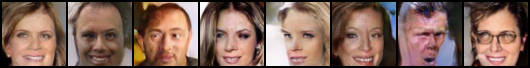

In [59]:
img = transforms.ToPILImage()(make_grid(G.to(device)(torch.randn(8,128, device=device)).detach().cpu(),
                                        normalize=True,ncol=2))
img

### The fourth task is to check model performance (3 pts)

1) Evaluate the FID metric for your model (3 pts)

Do not forget to use materials shared on seminars!

In [71]:
fid = FID(normalize=True).to(device)
for data in tqdm(dataloader):
    fid.update(1/2*(data.to(device)+1),real=True)

100%|███████████████████████████████████████| 3166/3166 [07:28<00:00,  7.06it/s]


In [72]:
N = 20000
for i in tqdm(range(N//batch_size)):
    fid.update(G.to(device)(1/2*(torch.randn(batch_size,128,device=device))+1),real=False)

100%|█████████████████████████████████████████| 312/312 [01:12<00:00,  4.33it/s]


In [81]:
# torch.save(fid, "fid10000.pth")

In [82]:
fid = torch.load("fid10000.pth", map_location = 'cuda:3')

In [83]:
fid.compute()

tensor(13.8514, device='cuda:3')

### The last task is to improve performance by correcting latent code sampling procedure (10 pts)

In this part you will implement I-SIR method to sample latent codes from corrected latent distribution and evaluate model performance with updated sampling using FID metric.

#### I-SIR (7 pts)

Algorithm:

* Sample $z \sim N(0,1)$ of shape $[N_s,1,n_z]$, where $n_z$ - size of latent space (128 for our model)

* FOR number of iterations $N_i$:
    * Sample additional particles $z_{\mathrm{add}} \sim N(0,1)$ of shape $[N_s,N_p,n_z]$
    * Concatenate $z$ with $z_{\mathrm{add}}$ along second dimension and reshape to the form $[-1,n_z]$. The result will be new $z$ of size $[N_s(N_p+1),n_z]$
    * Compute logarithm of density for new $z$ 
    
    $\log\rho(z) = -\frac{||z||_2^2}{2} + D(G(z))$ 
    
    and reshape result to the size $[N_s,N_p+1]$.
    * Make element-wise sampling from log density: fix first index and sample second one with respect to corresponding log density value (consider torch.distributions.Categorical). The result will be $idxs$ of size $[N_s]$.
    * Take particles according to sampled indexs $z = z[torch.arange(N_s),idxs]$.
* Return new samples $z$

#### Evaluate model using new sampling procedure (3 pts)

Compute FID metric by sampling latent code using I-SIR function. Leave a comment on obtained results.

In [87]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

def I_SIR(num_iterations, num_samples, num_particles, latent_dim, discriminator, generator):
    discriminator = discriminator.to(device)
    generator = generator.to(device)

    z = torch.randn(num_samples, 1, latent_dim, device=device) 
    
    for i in tqdm(range(num_iterations)):
        z_add = torch.randn(num_samples, num_particles, latent_dim, device=device)
        z_concat = torch.cat([z, z_add], dim=1).view(-1, latent_dim)
        log_density = (-torch.norm(z_concat, p=2, dim=1) ** 2 / 2 + discriminator(generator(z_concat)).squeeze()).view(num_samples, num_particles+1)
        idxs = dist.Categorical(logits=log_density).sample()
        z = z_concat.view(num_samples, num_particles+1, latent_dim)[torch.arange(num_samples), idxs].unsqueeze(1)

    z = z.squeeze(1) 

    return z

generated_samples = I_SIR(num_iterations=5000, num_samples=32, num_particles=5, latent_dim=128, discriminator=D, generator=G)

In [88]:
# Compute FID score
fid = FID(normalize=True).to(device)
for data in tqdm(dataloader):
    fid.update(data.to(device)/2+0.5,real=True)

In [89]:
N = 20000
for i in tqdm(range(N//32)):
    fid.update((G(z)) / 2 + 0.5, real=False)

In [90]:
# torch.save(fid, "fid10000_ISIR.pth")

In [95]:
fid = torch.load("fid10000_ISIR.pth", map_location = 'cuda:2')

In [96]:
fid.compute()

tensor(83.2415, device='cuda:2')

### Note 2

Honestly, I really not understand why my FID on I-SIR score is worse then FID on pure WGAN

# Problem 2. Signal processing (35 pts)

In this problem you are supposed to classify Electroencephalography (EEG) signals. You can solve the problem in two ways of your choice - using contrastive learning or using transformer.

## Dataset:

You will work with [EEG Motor Movement/Imagery Dataset (Sept. 9, 2009, midnight)](http://www.physionet.org/physiobank/database/eegmmidb/).
This data set consists of one-minute EEG recordings, obtained from 109 volunteers. 

We will consider Motor Imagenary experiment - a subject imagine opening and closing left or right fist. A target appears on either the left or the right side of the screen. The subject imagines opening and closing the corresponding fist until the target disappears. Then the subject relaxes.

The task is binary classify left and right hand movements from eeg signal.

Data loading \& requirements installation:

In [29]:
!pip install -q mne
!pip install -q torcheeg

In [2]:
import os
import mne
import numpy as np
from torcheeg import transforms
from torcheeg.datasets import MNEDataset
import torcheeg

import torch
from torch import nn
from tqdm import tqdm, notebook

In [3]:
metadata_list = [{
    'subject': subject_id,
    'run': run_id
} for subject_id in range(1, 100) # download of experiment data for subjects 1-100 (during debbuging you can take data for fewer subjects)
                 for run_id in [4, 8, 12]]  # Motor imagery experiment: left vs right hand

epochs_list = []
for metadata in notebook.tqdm(metadata_list):
    physionet_path = mne.datasets.eegbci.load_data(metadata['subject'],
                                                   metadata['run'],
                                                   update_path=False)[0]
    raw = mne.io.read_raw_edf(physionet_path, preload=True, stim_channel='auto')
    mne.datasets.eegbci.standardize(raw)

    montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(montage)

    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')
    events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
    picks = mne.pick_types(raw.info,
                           meg=False,
                           eeg=True,
                           stim=False,
                           eog=False,
                           exclude='bads')
    epochs_list.append(
        mne.Epochs(raw,
                   events,
                   dict(left=2, right=3),
                   tmin=-1.,
                   tmax=4.0,
                   proj=True,
                   picks=picks))

  0%|          | 0/297 [00:00<?, ?it/s]

Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R04.edf...
EDF file detected
Se

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Set

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R08.edf...
EDF file detected
Se

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R12.edf...
EDF file detected
Se

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 ma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
19 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S088/S088R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S090/S090R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S090/S090R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
19 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S092/S092R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15871  =      0.000 ...   123.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 213 samples (1.664 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
19 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower t

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R08.edf...
EDF file detected
Se

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection i

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Us

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info struct

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using default location ~/mne_data for EEGBCI...
Extracting EDF parameters from /home/d_sherki/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutof

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Let's see what the EEG recording looks like:

In [4]:
raw

<RawEDF | S099R12.edf, 64 x 19680 (123.0 s), ~9.7 MB, data loaded>

Using matplotlib as 2D backend.


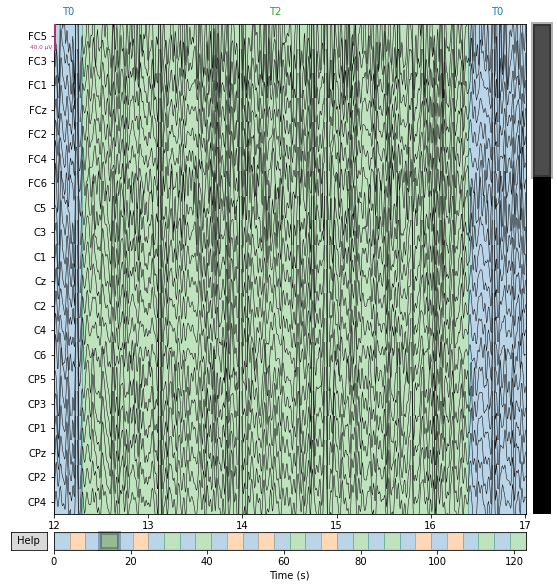

Effective window size : 12.800 (s)
Using data from preloaded Raw for 15 events and 801 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_20562/2662466424.py:2: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  raw.compute_psd().plot()


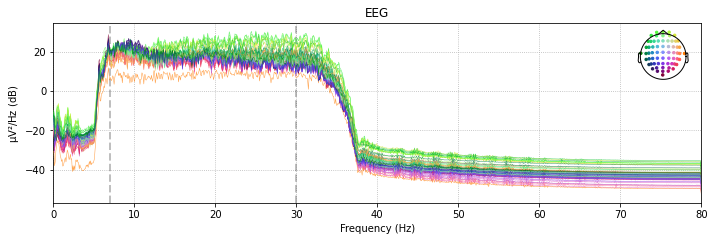

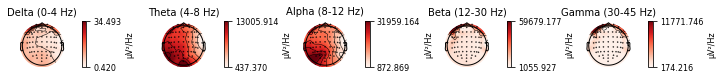

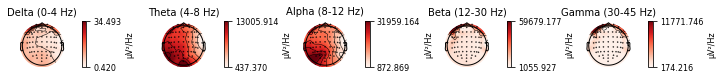

In [5]:
raw.plot(start = 12, duration = 5)
raw.compute_psd().plot()
epochs_list[-1].compute_psd().plot_topomap()

In [6]:
print(raw._data)
print("One sample data shape: ", raw._data.shape[0], "chanels x",  raw._data.shape[1], "signal length")

[[ 6.77626358e-21 -1.45717166e-05 -3.93417512e-05 ... -6.99019100e-05
  -5.48512304e-05 -4.60870912e-21]
 [-8.47032947e-21 -7.29407064e-06 -3.23210692e-05 ... -8.63485366e-05
  -6.78305393e-05 -6.32053174e-21]
 [ 6.77626358e-21 -4.74611842e-06 -1.76771611e-05 ... -6.84347096e-05
  -5.66778804e-05 -2.36113434e-21]
 ...
 [ 8.47032947e-21 -9.21410451e-06 -1.16907825e-05 ... -4.39956415e-05
  -3.00844994e-05  1.80969088e-20]
 [ 1.10114283e-20 -9.74920407e-06 -1.25823417e-05 ... -4.40928987e-05
  -2.95876499e-05  2.29880307e-20]
 [ 8.47032947e-22 -1.01831070e-05 -1.24798608e-05 ... -2.99396866e-05
  -2.10006595e-05  9.15248424e-21]]
One sample data shape:  64 chanels x 19680 signal length




Converting data into a usable form [[useful link]](https://torcheeg.readthedocs.io/en/latest/auto_examples/examples_mne_dataset.html):

In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from timm.data import Mixup
from timm.data.transforms_factory import create_transform
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torcheeg.model_selection import train_test_split_groupby_trial, KFold
from skimage.transform import AffineTransform

### Some little observation

Honestly, I wanted achieve baseline without any augmentation, but probably it is impossible((((

I use some existed function for augmentation, because ```torcheeg``` have limited functional

In [8]:
class MakeDistortion(object):
    def __init__(self, distortion_range=(-15, 15)):
        self.distortion_range = distortion_range
    
    def __call__(self, x):
        angle = np.random.uniform(*self.distortion_range)
        scale = np.random.uniform(0.8, 1.2)
        shear = np.random.uniform(-0.1, 0.1)
        transform_matrix = AffineTransform(rotation=angle, scale=scale, shear=shear)
        return warp(x, transform_matrix.inverse, output_shape=x.shape)

class MakeFlip(object):
    def __init__(self, flip_prob=0.5):
        self.flip_prob = flip_prob
    
    def __call__(self, x):
        if np.random.rand() < self.flip_prob:
            return np.flip(x, axis=1)
        else:
            return x
        
class Brightness(object):
    def __init__(self, brightness_range=(0.7, 1.3)):
        self.brightness_range = brightness_range
    
    def __call__(self, x):
        brightness_factor = np.random.uniform(*self.brightness_range)
        return np.clip(x * brightness_factor, 0, 1)

class Contrast(object):
    def __init__(self, contrast_range=(0.5, 1.5)):
        self.contrast_range = contrast_range
    
    def __call__(self, x):
        mean = np.mean(x)
        contrast_factor = np.random.uniform(*self.contrast_range)
        return np.clip((x - mean) * contrast_factor + mean, 0, 1)


### Some little observation №2

I tried to use ```torcheeg.make_selection.train_test_split_groupby_trial```, but ```train_test_split``` from ```sklearn``` really better for my idea:

1. I splitted whole dataset into the ```val_dataset``` and ```train_dataset```.
2. I added augmented part to ```train_dataset``` part and train it.

Honestly, I would augmented only train_dataset part, but I didn't get it how I can do it T_T


In [9]:
dataset = MNEDataset(epochs_list=epochs_list,
                     metadata_list=metadata_list,
                     chunk_size=160,
                     overlap=80,
                     io_path='./tmp_out/dataset/physionet',
                     offline_transform=transforms.Compose(
                         [transforms.MeanStdNormalize(),
                          transforms.To2d()]),
                     online_transform=transforms.ToTensor(),
                     label_transform=transforms.Compose([
                         transforms.Select('event'),
                         transforms.Lambda(lambda x: x - 2)
                     ]),
                     num_worker=2)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

augmented = MNEDataset(epochs_list=epochs_list,
                     metadata_list=metadata_list,
                     chunk_size=160,
                     overlap=80,
                     io_path='./tmp_out/dataset/physionet',
                     offline_transform=transforms.Compose(
                         [transforms.MeanStdNormalize(),
                          transforms.To2d(),
                          Brightness(),
                          Contrast(),
                          MakeFlip(),
                          MakeDistortion(),
                          transforms.Lambda(lambda x: adding_noise(x))]),
                     online_transform=transforms.Compose([transforms.ToTensor(),
                                                          transforms.RandomNoise(p=0.5),
#                                                           transforms.RandomShift(p=0.5),
#                                                           transforms.RandomMask(p=0.1),
#                                                           transforms.RandomFrequencyShift(p=0.5),
#                                                           transforms.RandomFlip(p=0.5),
                                                         ]),
                     label_transform=transforms.Compose([
                         transforms.Select('event'),
                         transforms.Lambda(lambda x: x - 2)
                     ]),
                     num_worker=2)

train_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented])

len(train_dataset)

[MNE]:   0%|                                            | 0/297 [00:00<?, ?it/s]

The current io_size is not enough, and double the LMDB map size to 20971520 automatically.
The current io_size is not enough, and double the LMDB map size to 41943040 automatically.



[MNE]:   0%|                                    | 1/297 [00:00<03:08,  1.57it/s]

The current io_size is not enough, and double the LMDB map size to 83886080 automatically.


[MNE]:   2%|▌                                   | 5/297 [00:01<00:59,  4.90it/s]

The current io_size is not enough, and double the LMDB map size to 167772160 automatically.


[MNE]:   4%|█▌                                 | 13/297 [00:02<00:44,  6.42it/s]

The current io_size is not enough, and double the LMDB map size to 335544320 automatically.


[MNE]:   9%|███▏                               | 27/297 [00:04<00:39,  6.90it/s]

The current io_size is not enough, and double the LMDB map size to 671088640 automatically.


[MNE]:  19%|██████▋                            | 57/297 [00:08<00:35,  6.80it/s]

The current io_size is not enough, and double the LMDB map size to 1342177280 automatically.


[MNE]:  39%|█████████████▏                    | 115/297 [00:17<00:28,  6.45it/s]

The current io_size is not enough, and double the LMDB map size to 2684354560 automatically.


[MNE]:  78%|██████████████████████████▍       | 231/297 [00:33<00:09,  6.75it/s]

The current io_size is not enough, and double the LMDB map size to 5368709120 automatically.


[MNE]: 100%|██████████████████████████████████| 297/297 [00:43<00:00,  6.83it/s]


Please wait for the writing process to complete...
The target folder already exists, if you need to regenerate the database IO, please delete the path ./tmp_out/dataset/physionet.


71890

## Contrastive learning approach (35 pts)


Obtaining EEG signals is generally straightforward, but labeling them is a costly and challenging task that requires extensive medical training. Additionally, EEG datasets often have noisy labels and limited numbers of subjects (less than 100). While supervised learning has been commonly used in the EEG signal analysis field, it has limitations in terms of generalization performance due to the scarcity of annotated data. Self-supervised learning, which is a popular learning paradigm in CV and NLP, can leverage unlabeled data to compensate for the shortage of supervised learning data.

Related articles:
*   http://proceedings.mlr.press/v136/mohsenvand20a/mohsenvand20a.pdf
*   https://arxiv.org/abs/2109.07839
*   https://arxiv.org/pdf/2106.14112.pdf


Your task is to adapt and fine-tune SimCLR to the problem. You are free to implement the task in any way. 

However, suggested pipeline is:


* Channel recombination (3pts)

To obtain additional valid channels from a multi-channel EEG recording, it is possible to recombine channels. Each channel of an EEG captures the voltage difference between a sensor and a common reference. By subtracting the voltage readings from two channels, a new channel can be created that represents the voltage difference between those two sensors. This approach can yield additional channels with meaningful neurophysiological information.


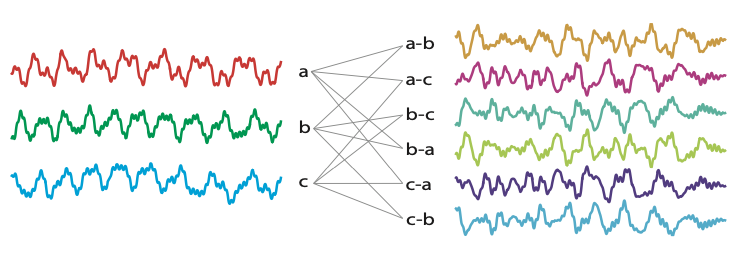


* Channel augmentations (3pts)

An essential element of the contrastive learning approach involves augmentations that do not affect the semantic information of data. A contrastive learning algorithm learns representations that are maximally similar for augmented instances of the same data-point and minimally similar for differ- ent data-points. For instance, the rotation of images or amplifying the amplitude of audio signals can significantly alter the numerical values of data, but not its meaning. Identifying a set of these augmentations can enable us to construct a self-supervised pretext task with the goal of generating features that are invulnerable to transformations and preserve the crucial content of EEG signals.


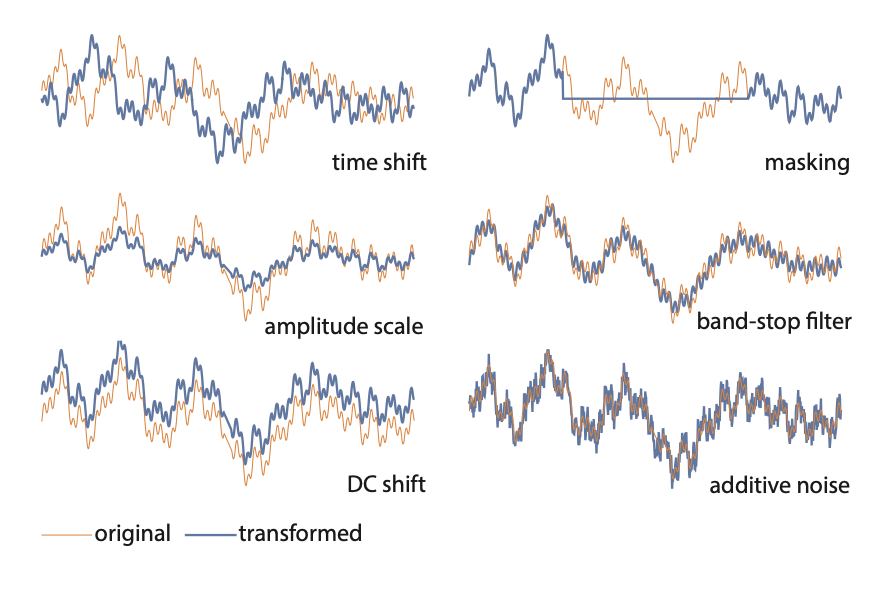

Modification variant of SimCLR proposed for EEG classification:

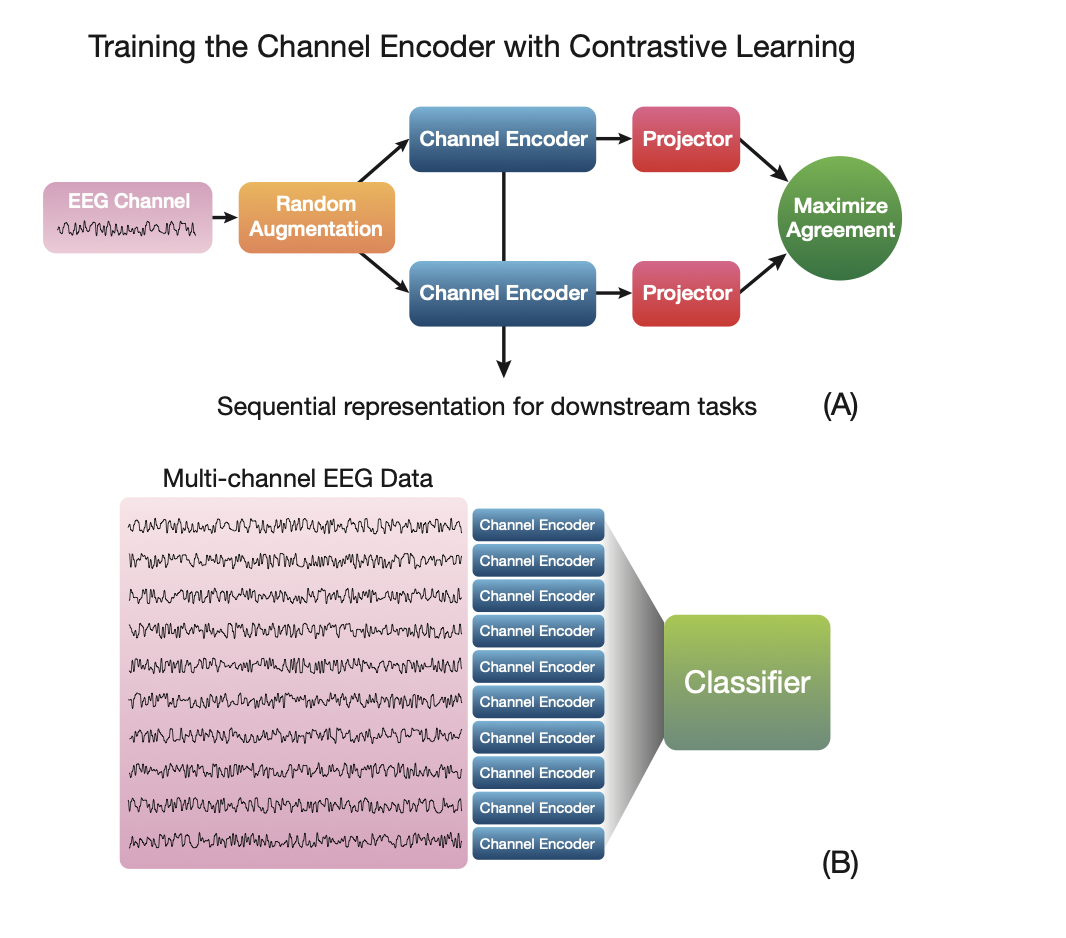

The model pipline consist of following bloks:


1. **Channel Encoder** (see picture below (A) and (B)) (4pts)
2. **Projector** (see picture below (C)) (4pts)
3. **Contrastive Loss** (4pts) Given a set $\left\{\boldsymbol{x}_k\right\}$ including a positive pair of channels $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$, the contrastive task aims to identify $\boldsymbol{x}_j$ in $\left\{\boldsymbol{x}_k\right\}_{k \neq i}$ for a given $\boldsymbol{x}_i$. Assuming that $\boldsymbol{z}_i$ and $\boldsymbol{z}_j$ are the outputs of the projector for the positive pair of $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$, the NT-Xent loss term for the positive pair is defined as:
$$
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_j\right) / \tau\right)}{\sum_{k \neq i}^{2 N} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_i, \boldsymbol{z}_k\right) / \tau\right)},
$$
where $\operatorname{sim}(\boldsymbol{u}, \boldsymbol{v})$ is the cosine similarity of $\boldsymbol{u}$ and $\boldsymbol{v}$ and $\tau$ is the temperature parameter. The final loss is the average of $\ell_{i, j}$ for all positive pairs in both orders $(i, j$ and $j, i)$.

4. **Classifier** (4pts)
A classifier almost identical to the projector with two differences: (1) the output dimension of the last dense layer is set to the number of classes (two in the current problem), and (2) a LogSoftmax layer is added afterward. 

(See more details in [paper](http://proceedings.mlr.press/v136/mohsenvand20a/mohsenvand20a.pdf))

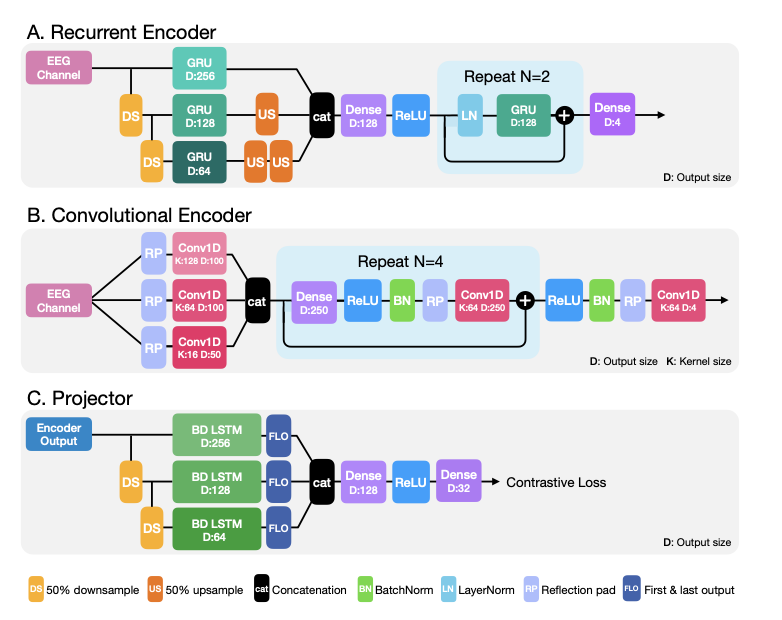

* **Data loader, Train loop \& Model trainig** (8pts)

* **Evaluate model**

Provide confusion matrix, F1 score, and loss curve.(3pts)

Report on obtained results.(2pts)





**You need to implement ONE of the two approaches!**

In [ ]:
### your code is here

## Transformer approach (35 pts)

The Transformer architecture has primarily found fame in processing natural language due to its excellent aptitude for analyzing long-range dependencies - this is beyond the fundamental capabilities delivered by conventional neural networks like CNN and RNN. As EEG classification significantly relies on capturing sequential relationships within the vast array of channels and time points, it has proven to be a difficult task, one that has frequently depended on pre-processing and hands-on feature extraction. However, deep learning with Transformer networks can remove the need for these preliminary steps by leveraging the attention mechanism to extract feature correlations in long-sequential EEG data, which helps visualize the model and appreciate the crucial spatial and temporal relationships in the raw data.

Related articles:
* https://www.nature.com/articles/s41598-022-18502-3
* https://arxiv.org/abs/2202.05170
* https://ieeexplore.ieee.org/document/9391844


In this task you need to implement transformer (you can use ViT transformers, but as a patch you need to use slice - signals splitted along the time dimension) *from scrath* .

**You need to implement ONE of the two approaches!**

### Code blocks (12 pts)

In [70]:
! python3 -m pip install einops -q

In [10]:
from einops import rearrange

In [11]:
# I use code for ViT transformer with some number of modification from ViT seminar
# I hope, it is not prohibitted (if it is not prohibitted: happy(); else: depressed())

class AttentionBlock(torch.nn.Module):
    def __init__(self, dim):      
        ### your code is here
        super().__init__()
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        
    def forward(self, x):
        ### your code is here
        '''
        Args: 
            x: Tensor of shape (batch_size, seq_len, input_dim)
            
        Returns:
            Tensor of shape (batch_size, seq_len, input_dim)
        '''
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.dim)
        q, k, v = qkv.unbind(2)
        # ...or q, k, v = [qkv[:, :, idx, :] for idx in range(3)]
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        x = attn @ v
        return x
    
class MultiHeadAttentionBlock(torch.nn.Module):
    def __init__(self, dim, num_heads=8):
        ### your code is here
        super().__init__()
        if dim % num_heads:
            raise ValueError('dim % num_heads != 0')
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)
    
    def forward(self, x):
        ### your code is here
        '''
        Args: 
            x: Tensor of shape (batch_size, seq_len, input_dim)
            
        Returns:
            Tensor of shape (batch_size, seq_len, input_dim)
        '''
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        # qkv: 3 × B × num_heads × N × head_dim
        q, k, v = qkv.unbind(0)
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        x = attn @ v  # attn: B × num_heads × N × N    v: B × num_heads × N × head_dim
        # B × num_heads × N × head_dim
        x = x.transpose(1, 2).reshape(B, N, C) 
        # B × N × (num_heads × head_dim)
        x = self.proj(x)
        return x
    
class Block(nn.Module):

    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4,  # ratio between hidden_dim and input_dim in MLP
            act_layer=nn.GELU,
            norm_layer=nn.LayerNorm
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = MultiHeadAttentionBlock(dim, num_heads=num_heads)
        self.norm2 = norm_layer(dim)
        self.mlp = nn.Sequential(nn.Linear(dim, dim * mlp_ratio), 
                                 act_layer(), 
                                 nn.Linear(dim * mlp_ratio, dim))

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
    

def img2patches(img, patch_size=8):
    '''
    Args:
        img: (batch_size, c, h, w) Tensor
        
    Returns:
        (batch_size, num_patches, vectorized_patch) Tensor
    '''
    return rearrange(img, 'batch_size c (h ph) (w pw) -> batch_size (h w) (c ph pw)', 
                     ph=patch_size, pw=patch_size)

class ViT(nn.Module):
    def __init__(self,
                img_size=(224, 224),
                patch_size=16,
                in_chans=3,
                num_classes=10,
                embed_dim=768,
                depth=12,
                num_heads=12,
                mlp_ratio=4,
                norm_layer=nn.LayerNorm,
                act_layer=nn.GELU
            ):
        # Your code is here
        super().__init__()
        self.patch_size = patch_size
        self.blocks = nn.Sequential(*[
            Block(embed_dim, num_heads, mlp_ratio, act_layer, norm_layer) for _ in range(depth)
        ])
        self.patch_proj = nn.Linear(1 * patch_size * patch_size, embed_dim) #nn.Linear(3 * patch_size * patch_size, embed_dim)
        self.embed_len = (img_size[0] * img_size[1]) // (patch_size * patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.embed_len, embed_dim) * .02)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        '''
        Args: 
            x: (batch_size, in_channels, img_size[0], img_size[1])
            
        Return:
            (batch_size, num_classes)
        '''
        x = img2patches(x, patch_size=self.patch_size)
        x = self.patch_proj(x)
        x = x + self.pos_embed
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.blocks(x)
        x = x[:, 0, :]  # take CLS token
        return self.head(x)

# class PositionalEncoding(torch.nn.Module):
#     def __init__(self, embed_dim, max_seq_len):
#       ### your code is here
#         super().__init__()
#         self.embed_dim = embed_dim
#         self.max_seq_len = max_seq_len
#         self.dropout = torch.nn.Dropout(p=0.1)
        
#         pe = torch.zeros(max_seq_len, embed_dim)
#         position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         ### your code is here
#         x = x * math.sqrt(self.embed_dim)
#         seq_len = x.size(1)
#         if seq_len > self.max_seq_len:
#             raise ValueError(f"Input sequence length {seq_len} exceeds maximum sequence length {self.max_seq_len}")
#         pe = self.pe[:seq_len, :]
#         x = x + pe.to(x.device)
#         return self.dropout(x) 

# class EncoderLayer(torch.nn.Module):
#     def __init__(self):
#       ### your code is here
#       pass      
#     def forward(self):
#       ### your code is here
#       pass

# class DecoderLayer(torch.nn.Module):
#     def __init__(self):
#       ### your code is here
#       pass          
#     def forward(self):
#       ### your code is here
#       pass

# class Transformer(torch.nn.Module):
#     ### your code is here
#     pass

* **Data loader, Train loop \& Model trainig** (8pts)

* **Evaluate model**

Provide confusion matrix, F1 score, and loss curve.(3pts)

Report on obtained results.(2pts)


In [12]:
# k_fold = KFold(n_splits=5, split_path='./tmp_out/examples_mne_dataset/split')
# train_dataset, val_dataset = train_test_split_groupby_trial(dataset=dataset, random_state=42,
#                                                           split_path='./tmp_out/examples_mne_dataset/split')


# Create data loaders for training and validation
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,
                          num_workers=8, pin_memory=True,  generator=g) #, collate_fn=mixup_fn
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                        num_workers=8, pin_memory=True, generator=g)

In [13]:
# Define the ViT model
model = ViT(img_size=(64, 160),
            patch_size=32,
            in_chans=1,
            num_classes=2,
            embed_dim=16,
            num_heads=16,
            depth=6,
            mlp_ratio=2,
            norm_layer=nn.LayerNorm,
            act_layer=nn.GELU).cuda()

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Train the model
accuracy_arr = []
max_acc = 0
loss_epoch = []
for epoch in tqdm(range(100)):
    loss_batch = []
    model.train()
    for step, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_batch.append(loss.item())
    loss_epoch.append(np.mean(loss_batch))
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100.0 * correct / total
    accuracy_arr.append(accuracy)
    if accuracy>max_acc:
        max_acc = accuracy
        torch.save(model.state_dict(), 'vit_2.pth')

    
    print(f'№ epoch: {epoch+1}, train_loss: {loss_epoch[-1] :.4f}, validation accuracy: {accuracy :.2f}%')

np.save('logging_2.npy',np.array([loss_epoch, accuracy_arr]))

  1%|▍                                          | 1/100 [00:35<59:21, 35.97s/it]

№ epoch: 1, train_loss: 0.6925, validation accuracy: 52.77%



  2%|▊                                          | 2/100 [01:12<59:25, 36.39s/it]

№ epoch: 2, train_loss: 0.6788, validation accuracy: 57.05%



  3%|█▎                                         | 3/100 [01:48<58:35, 36.25s/it]

№ epoch: 3, train_loss: 0.6623, validation accuracy: 58.45%



  4%|█▋                                         | 4/100 [02:24<57:51, 36.16s/it]

№ epoch: 4, train_loss: 0.6483, validation accuracy: 58.81%



  5%|██▏                                        | 5/100 [03:01<57:27, 36.29s/it]

№ epoch: 5, train_loss: 0.6349, validation accuracy: 60.05%



  6%|██▌                                        | 6/100 [03:37<57:03, 36.42s/it]

№ epoch: 6, train_loss: 0.6233, validation accuracy: 61.23%



  7%|███                                        | 7/100 [04:13<56:00, 36.13s/it]

№ epoch: 7, train_loss: 0.6102, validation accuracy: 62.09%



  8%|███▍                                       | 8/100 [04:49<55:30, 36.20s/it]

№ epoch: 8, train_loss: 0.5989, validation accuracy: 62.49%



  9%|███▊                                       | 9/100 [05:25<54:47, 36.12s/it]

№ epoch: 9, train_loss: 0.5861, validation accuracy: 63.96%



 10%|████▏                                     | 10/100 [06:01<54:04, 36.06s/it]

№ epoch: 10, train_loss: 0.5737, validation accuracy: 63.83%



 11%|████▌                                     | 11/100 [06:38<53:41, 36.20s/it]

№ epoch: 11, train_loss: 0.5614, validation accuracy: 65.36%



 12%|█████                                     | 12/100 [07:15<53:22, 36.39s/it]

№ epoch: 12, train_loss: 0.5494, validation accuracy: 66.14%



 13%|█████▍                                    | 13/100 [07:52<53:02, 36.59s/it]

№ epoch: 13, train_loss: 0.5356, validation accuracy: 65.74%



 14%|█████▉                                    | 14/100 [08:28<52:25, 36.58s/it]

№ epoch: 14, train_loss: 0.5241, validation accuracy: 66.99%



 15%|██████▎                                   | 15/100 [09:06<52:31, 37.07s/it]

№ epoch: 15, train_loss: 0.5138, validation accuracy: 67.69%



 16%|██████▋                                   | 16/100 [09:46<52:46, 37.70s/it]

№ epoch: 16, train_loss: 0.5020, validation accuracy: 67.86%



 17%|███████▏                                  | 17/100 [10:24<52:31, 37.97s/it]

№ epoch: 17, train_loss: 0.4914, validation accuracy: 68.57%



 18%|███████▌                                  | 18/100 [11:03<52:03, 38.09s/it]

№ epoch: 18, train_loss: 0.4818, validation accuracy: 68.84%



 19%|███████▉                                  | 19/100 [11:46<53:29, 39.62s/it]

№ epoch: 19, train_loss: 0.4728, validation accuracy: 68.87%



 20%|████████▍                                 | 20/100 [12:26<53:04, 39.80s/it]

№ epoch: 20, train_loss: 0.4642, validation accuracy: 69.80%



 21%|████████▊                                 | 21/100 [13:06<52:42, 40.03s/it]

№ epoch: 21, train_loss: 0.4542, validation accuracy: 69.78%



 22%|█████████▏                                | 22/100 [13:47<52:10, 40.14s/it]

№ epoch: 22, train_loss: 0.4472, validation accuracy: 70.32%



 23%|█████████▋                                | 23/100 [14:26<51:05, 39.81s/it]

№ epoch: 23, train_loss: 0.4363, validation accuracy: 70.93%



 24%|██████████                                | 24/100 [15:05<50:12, 39.63s/it]

№ epoch: 24, train_loss: 0.4291, validation accuracy: 71.57%



 25%|██████████▌                               | 25/100 [15:43<48:55, 39.13s/it]

№ epoch: 25, train_loss: 0.4196, validation accuracy: 71.33%



 26%|██████████▉                               | 26/100 [16:20<47:23, 38.43s/it]

№ epoch: 26, train_loss: 0.4133, validation accuracy: 71.38%



 27%|███████████▎                              | 27/100 [16:58<46:46, 38.44s/it]

№ epoch: 27, train_loss: 0.4053, validation accuracy: 72.47%



 28%|███████████▊                              | 28/100 [17:36<45:52, 38.23s/it]

№ epoch: 28, train_loss: 0.3989, validation accuracy: 73.23%



 29%|████████████▏                             | 29/100 [18:14<45:17, 38.27s/it]

№ epoch: 29, train_loss: 0.3926, validation accuracy: 73.31%



 30%|████████████▌                             | 30/100 [18:51<44:08, 37.83s/it]

№ epoch: 30, train_loss: 0.3869, validation accuracy: 73.44%



 31%|█████████████                             | 31/100 [19:29<43:37, 37.93s/it]

№ epoch: 31, train_loss: 0.3834, validation accuracy: 73.36%



 32%|█████████████▍                            | 32/100 [20:07<42:44, 37.71s/it]

№ epoch: 32, train_loss: 0.3788, validation accuracy: 73.69%



 33%|█████████████▊                            | 33/100 [20:43<41:34, 37.23s/it]

№ epoch: 33, train_loss: 0.3719, validation accuracy: 73.94%



 34%|██████████████▎                           | 34/100 [21:20<40:52, 37.16s/it]

№ epoch: 34, train_loss: 0.3664, validation accuracy: 74.00%



 35%|██████████████▋                           | 35/100 [21:56<40:05, 37.01s/it]

№ epoch: 35, train_loss: 0.3617, validation accuracy: 73.96%



 36%|███████████████                           | 36/100 [22:34<39:33, 37.09s/it]

№ epoch: 36, train_loss: 0.3548, validation accuracy: 74.59%



 37%|███████████████▌                          | 37/100 [23:10<38:36, 36.77s/it]

№ epoch: 37, train_loss: 0.3506, validation accuracy: 74.66%



 38%|███████████████▉                          | 38/100 [23:46<37:55, 36.70s/it]

№ epoch: 38, train_loss: 0.3479, validation accuracy: 75.54%



 39%|████████████████▍                         | 39/100 [24:23<37:22, 36.76s/it]

№ epoch: 39, train_loss: 0.3433, validation accuracy: 75.78%



 40%|████████████████▊                         | 40/100 [24:59<36:32, 36.53s/it]

№ epoch: 40, train_loss: 0.3373, validation accuracy: 75.61%



 41%|█████████████████▏                        | 41/100 [25:39<36:57, 37.58s/it]

№ epoch: 41, train_loss: 0.3354, validation accuracy: 76.15%



 42%|█████████████████▋                        | 42/100 [26:13<35:12, 36.43s/it]

№ epoch: 42, train_loss: 0.3277, validation accuracy: 76.23%



 43%|██████████████████                        | 43/100 [26:49<34:28, 36.29s/it]

№ epoch: 43, train_loss: 0.3257, validation accuracy: 76.66%



 44%|██████████████████▍                       | 44/100 [27:28<34:36, 37.08s/it]

№ epoch: 44, train_loss: 0.3188, validation accuracy: 76.06%



 45%|██████████████████▉                       | 45/100 [28:04<33:48, 36.88s/it]

№ epoch: 45, train_loss: 0.3164, validation accuracy: 76.64%



 46%|███████████████████▎                      | 46/100 [28:40<32:47, 36.43s/it]

№ epoch: 46, train_loss: 0.3124, validation accuracy: 76.92%



 47%|███████████████████▋                      | 47/100 [29:17<32:24, 36.70s/it]

№ epoch: 47, train_loss: 0.3096, validation accuracy: 76.87%



 48%|████████████████████▏                     | 48/100 [29:56<32:19, 37.29s/it]

№ epoch: 48, train_loss: 0.3091, validation accuracy: 77.09%



 49%|████████████████████▌                     | 49/100 [30:37<32:47, 38.57s/it]

№ epoch: 49, train_loss: 0.3020, validation accuracy: 77.59%



 50%|█████████████████████                     | 50/100 [31:16<32:15, 38.71s/it]

№ epoch: 50, train_loss: 0.2986, validation accuracy: 78.27%



 51%|█████████████████████▍                    | 51/100 [31:54<31:22, 38.41s/it]

№ epoch: 51, train_loss: 0.2961, validation accuracy: 78.61%



 52%|█████████████████████▊                    | 52/100 [32:33<30:51, 38.57s/it]

№ epoch: 52, train_loss: 0.2924, validation accuracy: 78.78%



 53%|██████████████████████▎                   | 53/100 [33:10<29:56, 38.22s/it]

№ epoch: 53, train_loss: 0.2899, validation accuracy: 78.81%



 54%|██████████████████████▋                   | 54/100 [33:49<29:28, 38.44s/it]

№ epoch: 54, train_loss: 0.2836, validation accuracy: 79.04%



 55%|███████████████████████                   | 55/100 [34:28<28:55, 38.57s/it]

№ epoch: 55, train_loss: 0.2832, validation accuracy: 77.92%



 56%|███████████████████████▌                  | 56/100 [35:07<28:24, 38.74s/it]

№ epoch: 56, train_loss: 0.2804, validation accuracy: 78.67%



 57%|███████████████████████▉                  | 57/100 [35:45<27:33, 38.44s/it]

№ epoch: 57, train_loss: 0.2777, validation accuracy: 78.37%



 58%|████████████████████████▎                 | 58/100 [36:23<26:52, 38.39s/it]

№ epoch: 58, train_loss: 0.2728, validation accuracy: 79.23%



 59%|████████████████████████▊                 | 59/100 [37:01<26:09, 38.28s/it]

№ epoch: 59, train_loss: 0.2720, validation accuracy: 79.52%



 60%|█████████████████████████▏                | 60/100 [37:40<25:42, 38.57s/it]

№ epoch: 60, train_loss: 0.2735, validation accuracy: 79.67%



 61%|█████████████████████████▌                | 61/100 [38:19<25:06, 38.63s/it]

№ epoch: 61, train_loss: 0.2668, validation accuracy: 79.58%



 62%|██████████████████████████                | 62/100 [38:58<24:30, 38.70s/it]

№ epoch: 62, train_loss: 0.2641, validation accuracy: 80.30%



 63%|██████████████████████████▍               | 63/100 [39:37<23:48, 38.61s/it]

№ epoch: 63, train_loss: 0.2612, validation accuracy: 79.96%



 64%|██████████████████████████▉               | 64/100 [40:15<23:12, 38.68s/it]

№ epoch: 64, train_loss: 0.2634, validation accuracy: 80.42%



 65%|███████████████████████████▎              | 65/100 [40:55<22:47, 39.08s/it]

№ epoch: 65, train_loss: 0.2504, validation accuracy: 80.48%



 66%|███████████████████████████▋              | 66/100 [41:34<22:03, 38.93s/it]

№ epoch: 66, train_loss: 0.2613, validation accuracy: 79.66%



 67%|████████████████████████████▏             | 67/100 [42:13<21:21, 38.84s/it]

№ epoch: 67, train_loss: 0.2480, validation accuracy: 80.97%



 68%|████████████████████████████▌             | 68/100 [42:50<20:28, 38.39s/it]

№ epoch: 68, train_loss: 0.2477, validation accuracy: 80.60%



 69%|████████████████████████████▉             | 69/100 [43:30<20:01, 38.77s/it]

№ epoch: 69, train_loss: 0.2487, validation accuracy: 80.95%



 70%|█████████████████████████████▍            | 70/100 [44:09<19:27, 38.91s/it]

№ epoch: 70, train_loss: 0.2443, validation accuracy: 80.61%



 71%|█████████████████████████████▊            | 71/100 [44:47<18:45, 38.83s/it]

№ epoch: 71, train_loss: 0.2403, validation accuracy: 81.10%



 72%|██████████████████████████████▏           | 72/100 [45:26<18:04, 38.74s/it]

№ epoch: 72, train_loss: 0.2430, validation accuracy: 81.20%



 73%|██████████████████████████████▋           | 73/100 [46:06<17:32, 38.98s/it]

№ epoch: 73, train_loss: 0.2383, validation accuracy: 81.80%



 74%|███████████████████████████████           | 74/100 [46:43<16:42, 38.55s/it]

№ epoch: 74, train_loss: 0.2367, validation accuracy: 81.46%



 75%|███████████████████████████████▌          | 75/100 [47:22<16:07, 38.70s/it]

№ epoch: 75, train_loss: 0.2304, validation accuracy: 82.64%



 76%|███████████████████████████████▉          | 76/100 [48:01<15:31, 38.81s/it]

№ epoch: 76, train_loss: 0.2364, validation accuracy: 81.56%



 77%|████████████████████████████████▎         | 77/100 [48:40<14:53, 38.84s/it]

№ epoch: 77, train_loss: 0.2263, validation accuracy: 81.36%



 78%|████████████████████████████████▊         | 78/100 [49:20<14:20, 39.11s/it]

№ epoch: 78, train_loss: 0.2272, validation accuracy: 82.95%



 79%|█████████████████████████████████▏        | 79/100 [49:59<13:39, 39.01s/it]

№ epoch: 79, train_loss: 0.2251, validation accuracy: 83.58%



 80%|█████████████████████████████████▌        | 80/100 [50:38<12:59, 39.00s/it]

№ epoch: 80, train_loss: 0.2230, validation accuracy: 82.44%



 81%|██████████████████████████████████        | 81/100 [51:17<12:22, 39.06s/it]

№ epoch: 81, train_loss: 0.2245, validation accuracy: 82.24%



 82%|██████████████████████████████████▍       | 82/100 [51:56<11:42, 39.03s/it]

№ epoch: 82, train_loss: 0.2203, validation accuracy: 82.75%



 83%|██████████████████████████████████▊       | 83/100 [52:37<11:13, 39.64s/it]

№ epoch: 83, train_loss: 0.2191, validation accuracy: 82.56%



 84%|███████████████████████████████████▎      | 84/100 [53:16<10:32, 39.54s/it]

№ epoch: 84, train_loss: 0.2180, validation accuracy: 81.80%



 85%|███████████████████████████████████▋      | 85/100 [53:55<09:49, 39.31s/it]

№ epoch: 85, train_loss: 0.2165, validation accuracy: 84.45%



 86%|████████████████████████████████████      | 86/100 [54:33<09:05, 38.97s/it]

№ epoch: 86, train_loss: 0.2122, validation accuracy: 81.28%



 87%|████████████████████████████████████▌     | 87/100 [55:09<08:14, 38.07s/it]

№ epoch: 87, train_loss: 0.2183, validation accuracy: 81.11%



 88%|████████████████████████████████████▉     | 88/100 [55:48<07:39, 38.26s/it]

№ epoch: 88, train_loss: 0.2116, validation accuracy: 83.61%



 89%|█████████████████████████████████████▍    | 89/100 [56:26<07:01, 38.31s/it]

№ epoch: 89, train_loss: 0.2109, validation accuracy: 83.19%



 90%|█████████████████████████████████████▊    | 90/100 [57:04<06:22, 38.21s/it]

№ epoch: 90, train_loss: 0.2060, validation accuracy: 83.63%



 91%|██████████████████████████████████████▏   | 91/100 [57:43<05:46, 38.46s/it]

№ epoch: 91, train_loss: 0.2034, validation accuracy: 84.38%



 92%|██████████████████████████████████████▋   | 92/100 [58:23<05:10, 38.83s/it]

№ epoch: 92, train_loss: 0.2072, validation accuracy: 84.23%



 93%|███████████████████████████████████████   | 93/100 [59:02<04:32, 38.88s/it]

№ epoch: 93, train_loss: 0.1998, validation accuracy: 82.55%



 94%|███████████████████████████████████████▍  | 94/100 [59:42<03:55, 39.22s/it]

№ epoch: 94, train_loss: 0.2010, validation accuracy: 84.06%



 95%|██████████████████████████████████████  | 95/100 [1:00:18<03:11, 38.22s/it]

№ epoch: 95, train_loss: 0.2033, validation accuracy: 84.39%



 96%|██████████████████████████████████████▍ | 96/100 [1:00:56<02:32, 38.17s/it]

№ epoch: 96, train_loss: 0.1921, validation accuracy: 84.64%



 97%|██████████████████████████████████████▊ | 97/100 [1:01:34<01:54, 38.16s/it]

№ epoch: 97, train_loss: 0.1996, validation accuracy: 85.23%



 98%|███████████████████████████████████████▏| 98/100 [1:02:12<01:16, 38.12s/it]

№ epoch: 98, train_loss: 0.1973, validation accuracy: 84.68%



 99%|███████████████████████████████████████▌| 99/100 [1:02:50<00:38, 38.13s/it]

№ epoch: 99, train_loss: 0.1952, validation accuracy: 83.56%


100%|███████████████████████████████████████| 100/100 [1:03:30<00:00, 38.10s/it]

№ epoch: 100, train_loss: 0.1974, validation accuracy: 85.03%


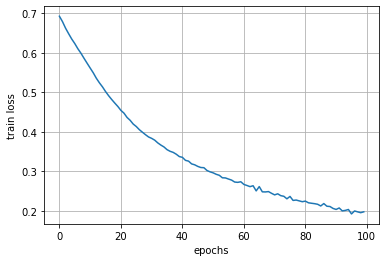

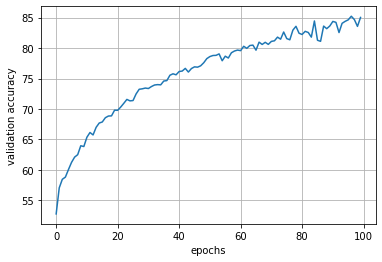

In [27]:
import matplotlib.pyplot as plt

plt.plot(loss_epoch)
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.grid(True)
plt.show()

plt.plot(accuracy_arr)
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.grid(True)
plt.show()

In [15]:
model = ViT(img_size=(64, 160),
            patch_size=32,
            in_chans=1,
            num_classes=2,
            embed_dim=16,
            num_heads=16,
            depth=6,
            mlp_ratio=2,
            norm_layer=nn.LayerNorm,
            act_layer=nn.GELU).cuda()
model.load_state_dict(torch.load('vit_2.pth'))

<All keys matched successfully>

In [19]:
all_loader = DataLoader(dataset, batch_size=64, shuffle=False,
                        num_workers=8, pin_memory=True, generator=g) #without augmented samples

In [20]:
def get_y_pred_true(model, dataloader):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs, labels = data
            outputs = model(inputs.cuda())
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.detach().cpu().numpy())
            y_true.extend(labels.numpy())
    return y_pred, y_true

In [21]:
def metrics_report(y_true, y_pred, loader_name):
    print(f'FOR {loader_name} DATALOADER:')
    print(f'Confusion matrix \n{confusion_matrix(y_true, y_pred)}')
    print(f'Accuracy on validation dataset {accuracy_score(y_true, y_pred)*100 :.2f}%')
    print(f'F1-score on validation dataset {f1_score(y_true, y_pred)*100 :.2f}%')

In [22]:
for loader, name in zip([train_loader, val_loader, all_loader],
                       ['TRAIN', 'TEST', 'ALL']):
    y_pred, y_true = get_y_pred_true(model, loader)
    metrics_report(y_pred, y_true, name)

100%|██████████████████████████████████████| 1124/1124 [00:07<00:00, 148.89it/s]


FOR TRAIN DATALOADER:
Confusion matrix 
[[33672  1788]
 [ 2580 33850]]
Accuracy on validation dataset 93.92%
F1-score on validation dataset 93.94%


100%|█████████████████████████████████████████| 125/125 [00:01<00:00, 68.70it/s]


FOR TEST DATALOADER:
Confusion matrix 
[[3348  504]
 [ 676 3460]]
Accuracy on validation dataset 85.23%
F1-score on validation dataset 85.43%


100%|████████████████████████████████████████| 625/625 [00:04<00:00, 127.37it/s]

FOR ALL DATALOADER:
Confusion matrix 
[[18510  1146]
 [ 1628 18655]]
Accuracy on validation dataset 93.05%
F1-score on validation dataset 93.08%


### Obtained results

I take really good model, but without any augmentation this model have approximately 58% accuracy on test set

Augmentation is really helps!

### Efficient transformers (10 pts)

One of the key issues in a transformer is its quadratic complexity in relation to the length of the input sequence. This quadratic complexity can be computationally expensive, making it harder to scale transformers to longer sequences. Specifically, computing the attention matrix requires an $O(N^2)$ operation per layer, where $N$ is the length of the input sequence. This makes training and inference for large input sequences infeasible due to limitations in the available computational resources. 


Propose 2 implementation of eficient transformers, provide references and main idea of selected approaches. (2 pts)

Implement one of the approaches, compare inference with the previous model, make a conclusion. (8 pts)


## Efficient transformers

I really tried to find some paper where the attention block in vision transformer have a linear complexity but probably I won 't have time to decribe it((( Please get my apologize!!! This task is defenetely interesting

"Going Deeper with Image Transformers" by Hugo Touvron, Matthieu Cord, et al. (arXiv:2103.17239): https://arxiv.org/abs/2103.17239

"Training data-efficient image transformers & distillation through attention" by Aravindh Mahendran, et al. (arXiv:2012.12877): https://arxiv.org/abs/2012.12877

"An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Alexey Dosovitskiy, et al. (arXiv:2010.11929): https://arxiv.org/abs/2010.11929

"Visualizing and Understanding Transformer-Based Language Models" by Jay Alammar: This blog post provides a clear explanation of the attention mechanism in transformer-based models, including the vision transformer architecture. It also includes visualizations that make it easy to understand how attention works. You can find it here: http://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/

"The Illustrated Transformer" by Jay Alammar: This blog post provides an illustrated guide to the transformer architecture, which is used in vision transformers. It includes simple explanations and diagrams that make it easy to understand how the model works. You can find it here: http://jalammar.github.io/illustrated-transformer/

In [ ]:
### your code is here